# Social Graphs Project

## Pre-processing

### Imports

In [385]:
import pandas as pd
import numpy as np
import re
import urllib.request
import json
import os
import string  
import math
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import networkx as nx
import community
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from fa2 import ForceAtlas2
from PIL import Image, ImageFont
import requests
import json
import re
!pip install plotly
!pip install altair
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import altair as alt 
import warnings
warnings.filterwarnings('ignore')

In [386]:
# define colors
blue = ['#c8e1ff','#79b8ff','#0366d6','#044289','#05264c','#191970']

### Extract wiki data

In [387]:
# data scraping from Github API (...)

### Data cleaning

In [388]:
# load scraped data
df = pd.read_csv('data/final_data.csv', converters={'following': eval,'repos_name': eval}, index_col=0)

# convert the used_languages to a list of strings
df['used_languages'] = df['used_languages'].str.replace(' ',',').str.replace('\n','').str.replace("'","")
def stringToList(colname):
    df[colname] = [df[colname][i][1:len(df[colname][i])-1].split(',') for i in range(len(df))]
stringToList('used_languages')

# display dataframe
df.head()

,user_name,owner,repos,name,type,company,location,bio,created_at,updated_at,...,email,followers_count,following_count,hireable,repos_count,repos_name,total_stars,total_forks,main_language,used_languages
0,josephmisiti,josephmisiti,awesome-machine-learning,Joseph Misiti,User,Math & Pencil,"Brooklyn, NY",Mathematician & Co-founder of Math & Pencil,2010-04-17T21:09:13Z,2020-10-29T18:11:39Z,...,NaN,2610,275,True,226,"[80s.nyc, alexa-skills-kit-js, algodeck, algor...",48727,12605,Python,"[C, C++, CSS, CoffeeScript, Go, HTML, Java, Ja..."
1,wepe,wepe,MachineLearning,wepon,User,AntFin,China Hangzhou,NaN,2014-10-10T14:28:18Z,2020-11-05T15:54:10Z,...,wepon@pku.edu.cn,4564,47,NaN,27,"[AliTianChi, CaiNiao-DemandForecast-StoragePla...",7324,5193,Python,"[C++, HTML, Java, Python, Shell]"
2,ZuzooVn,ZuzooVn,machine-learning-for-software-engineers,Nam Vu,User,NaN,Vietnam,A Vietnamese Software Engineer who is really p...,2012-02-11T16:55:02Z,2020-10-12T02:40:45Z,...,zuzoovn@gmail.com,1223,91,True,38,"[android-classyshark, asi-http-request, awesom...",24471,5838,Python,"[C, DIGITAL, Command, Language, HTML, Java, Ja..."
3,rasbt,rasbt,python-machine-learning-book,Sebastian Raschka,User,UW-Madison,"Madison, WI",Machine Learning researcher & open source cont...,2013-10-05T16:06:10Z,2020-11-09T23:00:46Z,...,NaN,13401,35,NaN,69,"[advent-of-code-2016, algorithms_in_ipython_no...",50787,16673,Python,"[C, C++, CSS, HTML, Jupyter, Notebook, Lua, Op..."
4,Jack-Cherish,Jack-Cherish,Machine-Learning,Jack Cui,User,Northeastern University,China,:octocat:公众号：JackCui-AI,2016-01-25T03:38:06Z,2020-07-31T13:54:15Z,...,c411184003@gmail.com,3181,28,NaN,14,"[Algorithm, C, DataSet, Deep-Learning, DeepLea...",16969,8649,Python,"[C++, HTML, Python]"


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 0 to 1584
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_name        1585 non-null   object
 1   owner            1585 non-null   object
 2   repos            1585 non-null   object
 3   name             1345 non-null   object
 4   type             1585 non-null   object
 5   company          768 non-null    object
 6   location         1008 non-null   object
 7   bio              691 non-null    object
 8   created_at       1585 non-null   object
 9   updated_at       1585 non-null   object
 10  following        1585 non-null   object
 11  description      1542 non-null   object
 12  blog             752 non-null    object
 13  email            620 non-null    object
 14  followers_count  1585 non-null   int64 
 15  following_count  1585 non-null   int64 
 16  hireable         364 non-null    object
 17  repos_count      1585 non-null   

In [390]:
# create additional variable for 'following' with only the users that exist in the 'user_name' variable already
df['following_relevant'] = ''
for i in range(len(df)):
    df['following_relevant'][i] = np.unique([link for link in df['following'][i] if link in df['user_name'].values])

## Generate network

In [391]:
# store the network of users with DiGraph
G = nx.DiGraph()

# add nodes as users
G.add_nodes_from(df['user_name'].values)

# add edges as users following each other 
for row in df.iterrows():
    z = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant']]
    G.add_edges_from(z)
    
# extract giant connected component 
largest_cc = max(nx.weakly_connected_components(G), key=len)
GCC = G.subgraph(largest_cc)

## Network statistics

### Total network nodes and edges

In [392]:
print(f"Number of nodes in graph: {G.number_of_nodes()}")
print(f"Number of edges in graph: {G.number_of_edges()}")

Number of nodes in graph: 1585
Number of edges in graph: 2092


In [393]:
# find highest in-degree nodes in network
df['in_degree'] = df['user_name'].apply(lambda x: G.in_degree(x))
print('Top 5 in-degree nodes')
display(df.sort_values(by=['in_degree'], ascending=False)[['user_name','name','in_degree']].head())

# find highest out-degree nodes in network
df['out_degree'] = df['user_name'].apply(lambda x: G.out_degree(x))
print('Top 5 out-degree nodes')
display(df.sort_values(by=['out_degree'], ascending=False)[['user_name','name','out_degree']].head())

# find highest connected (in and out-degree) nodes
df['degree'] = df['user_name'].apply(lambda x: G.degree(x))
print('Top 5 degree nodes')
display(df.sort_values(by=['degree'], ascending=False)[['user_name','name','degree']].head())

Top 5 in-degree nodes


,user_name,name,in_degree
367,amueller,Andreas Mueller,67
417,ogrisel,Olivier Grisel,63
574,fchollet,François Chollet,58
26,llSourcell,Siraj Raval,56
3,rasbt,Sebastian Raschka,55


Top 5 out-degree nodes


,user_name,name,out_degree
1178,yupbank,Peng Yu,68
575,feihugis,Fei Hu,43
1124,gaocegege,Ce Gao,42
1320,silverstone1903,NaN,41
1042,justinormont,Justin Ormont,36


Top 5 degree nodes


,user_name,name,degree
367,amueller,Andreas Mueller,83
417,ogrisel,Olivier Grisel,82
1178,yupbank,Peng Yu,72
155,soumith,Soumith Chintala,64
3,rasbt,Sebastian Raschka,60


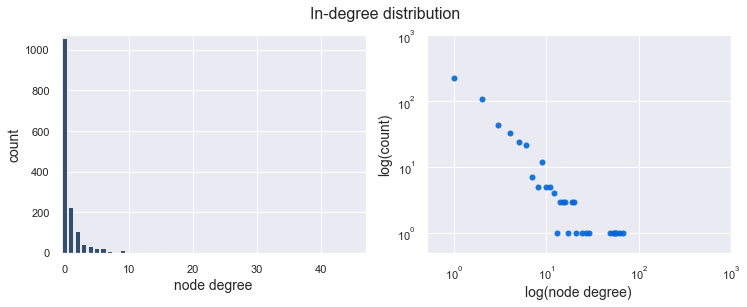

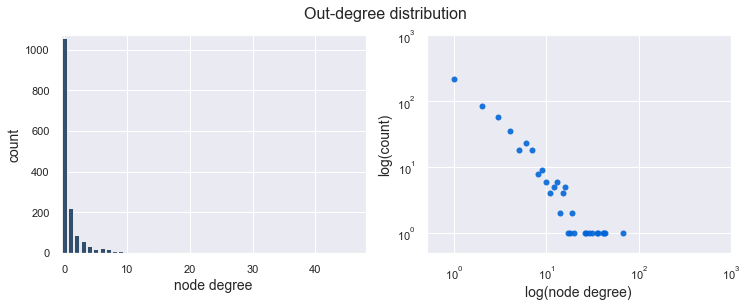

In [394]:
def degree_distribution(G, mode):
    
    # find in or out degrees of network
    if mode.lower() == 'in':
        degree_sequence = [d for n, d in G.in_degree()]
    else:
        degree_sequence = [d for n, d in G.out_degree()]
    # find min and max of degrees     
    dmax = max(degree_sequence)
    dmin = min(degree_sequence)
    
    # compute frequencies of degrees distribution
    counts, bins = np.histogram(degree_sequence, bins = np.arange(dmin-0.5, dmax+1.5,1))
    
    # set style, figure size and title
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,4])
    fig.suptitle(mode+'-degree distribution',fontsize=16)
    
    # plot histogram 
    ax1.bar(np.arange(dmin, dmax+1,1), counts, color=blue[4], alpha=0.8)
    ax1.set_xlim(-0.5, dmax-20)
    ax1.set_ylim(-0.5, max(counts)+10)
    ax1.set_xlabel('node degree',fontsize=14)
    ax1.set_ylabel('count',fontsize=14)
    
    # plot scatter plot on log-log scale
    ax2.loglog(np.arange(dmin, dmax+1,1), counts, 'o', color=blue[2], alpha=0.9)
    ax2.set_xlim(0.5, 10**3)
    ax2.set_ylim(0.5, 10**3)
    ax2.set_xlabel('log(node degree)',fontsize=14)
    ax2.set_ylabel('log(count)',fontsize=14)
    plt.show()
    
degree_distribution(G,'In')
degree_distribution(G,'Out')

### GCC nodes and edges

In [395]:
print(f"Number of nodes in GCC: {GCC.number_of_nodes()}")
print(f"Number of edges in GCC: {GCC.number_of_edges()}")

Number of nodes in GCC: 737
Number of edges in GCC: 2072


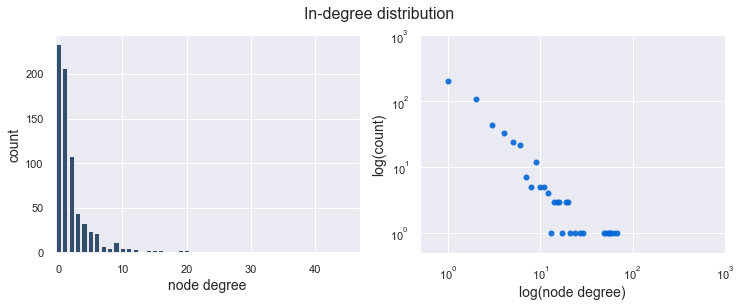

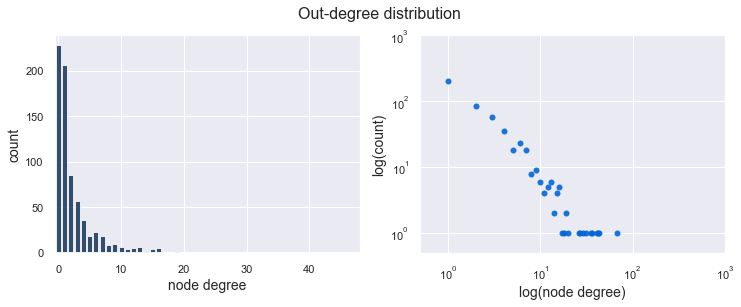

In [396]:
degree_distribution(GCC,'In')
degree_distribution(GCC,'Out')

### Bar charts

In [397]:
top_followers = df.sort_values(by='followers_count', axis=0, ascending=False)
fig = px.bar(top_followers[:100], x='user_name', y='followers_count', hover_data=['followers_count'])
fig.update_layout(height=450, width=750, title_text='The most popular users')
fig.show()

In [398]:
top_following = df.sort_values(by='following_count', axis=0, ascending=False)
fig = px.bar(top_following[:100], x='user_name', y='following_count', hover_data=['following_count'])
fig.update_layout(height=450, width=750, title_text='Fan users following other users the most')
fig.show()

In [399]:
# determine what percentage of followers top 1% of users get
top = int(len(top_followers) * 0.01)
perc = sum(top_followers.iloc[0: top,:].loc[:, 'followers_count'])/sum(top_followers.followers_count)*100
print(f'1 % of the top users have {round(perc,1)} % of the followers')

1 % of the top users have 42.2 % of the followers


In [435]:
top_followers = df.sort_values(by='followers_count', axis=0, ascending=False)
fig = px.bar(top_followers[:100], x='user_name', y='followers_count', hover_data=['followers_count'])
fig.update_layout(height=450, width=750, title_text='The most popular users')
fig.show()

In [400]:
top_stars = df.sort_values(by='total_stars', axis=0, ascending=False)
fig = px.bar(top_stars[:100], x='user_name', y='total_stars', hover_data=['total_stars'])
fig.update_layout(height=450, width=750, title_text='Users with the most stars')
fig.show()

In [401]:
top_forks = df.sort_values(by='total_forks', axis=0, ascending=False)
fig = px.bar(top_forks[:100], x='user_name', y='total_forks', hover_data=['total_forks'])
fig.update_layout(height=450, width=750, title_text='Users with the most forks')
fig.show()

In [434]:
top_repos = df.sort_values(by='repos_count', axis=0, ascending=False)
fig = px.bar(top_repos[:100], x='user_name', y='repos_count', hover_data=['repos_count'])
fig.update_layout(height=450, width=750, title_text='Users with the most repositories')
fig.show()

### Correlation

In [404]:
corr = px.scatter_matrix(df, dimensions=['followers_count','following_count','total_stars','total_forks','repos_count'],
                         title='Correlation', height=750, width=750)
corr.show()

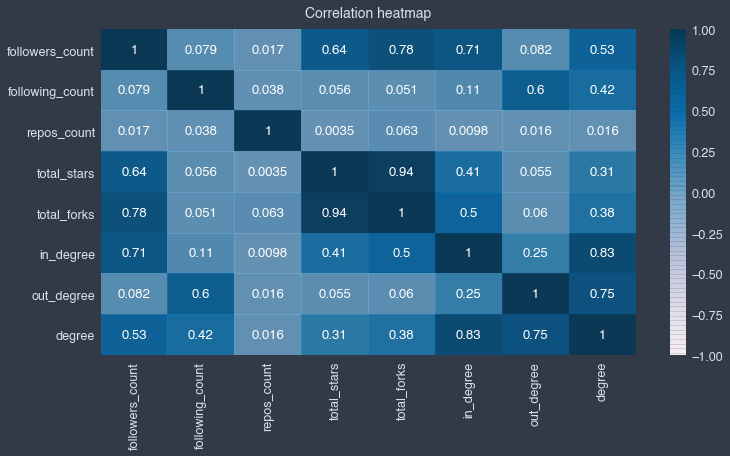

In [405]:
jtplot.style('chesterish')
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='PuBu', alpha=0.8)
heatmap.set_title('Correlation heatmap', fontsize=14, pad=12)
plt.show()

## Visualization

### Network visualization

In [406]:
# convert to undirected graph
giant = GCC.to_undirected()

# scale node-size according to degree
d = dict(giant.degree)
sizes = [v * 10 for v in d.values()]

# specify settings for the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
    # behavior alternatives
    outboundAttractionDistribution=True, # dissuade hubs
    linLogMode=False,  
    adjustSizes=False,
    edgeWeightInfluence=1.0,

    # performance
    jitterTolerance=1.0,  # tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  

    # tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # log
    verbose=True)

# get positions based on theForce Atlas 2 algorithm
positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=3000)

100%|██████████| 3000/3000 [00:14<00:00, 209.59it/s]

BarnesHut Approximation  took  4.72  seconds
Repulsion forces  took  8.54  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.40  seconds


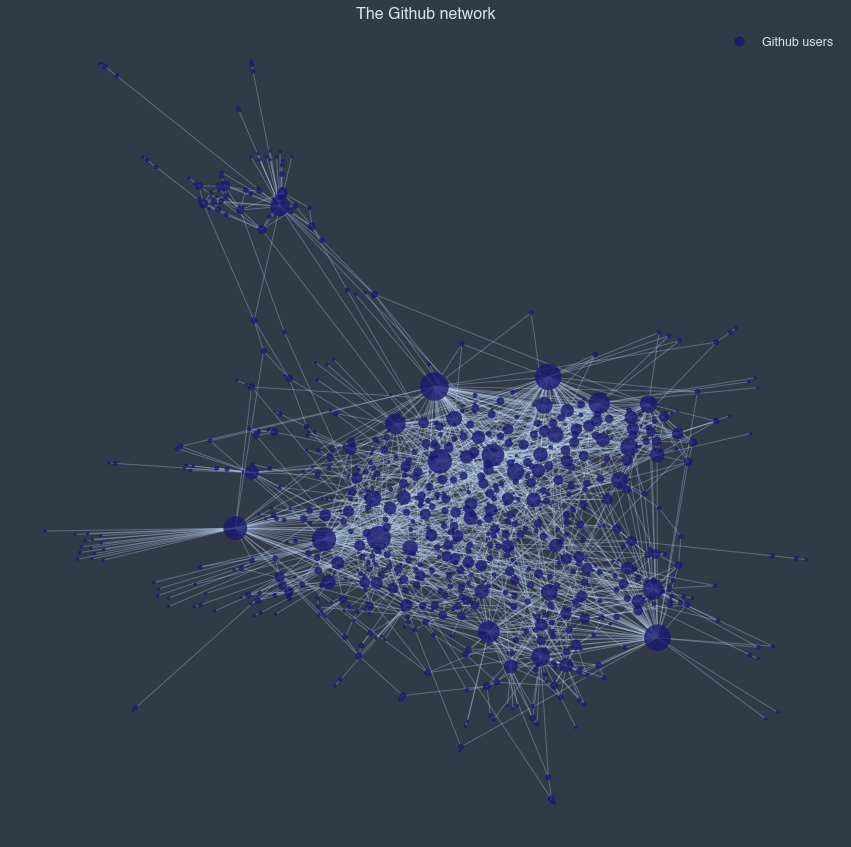

In [407]:
# set style, figure size and title
jtplot.style('chesterish')
fig = plt.figure(figsize=(15,15))
plt.title('The Github network', fontsize=16)

# draw network
nx.draw_networkx_nodes(giant, positions, node_color=blue[5], alpha=0.8, node_size=sizes)
nx.draw_networkx_edges(giant, positions, edge_color=blue[0], alpha=0.3)
 
# create legend and remove axes 
plt.scatter([], [], c=blue[5], alpha=0.9, s=100, label='Github users')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1)
plt.axis('off')

plt.show()
fig.savefig('network.png', facecolor=fig.get_facecolor(), transparent=True)

### Communities

In [408]:
# find communities in the network
partition = community.best_partition(giant, random_state=26)
size = float(len(set(partition.values())))
print(f'Number of communities: {size}')

Number of communities: 15.0


In [409]:
df_gcc = df[df['user_name'].isin(list(GCC.nodes))]
df_gcc.reset_index(drop=True)
df_gcc.head(3)

,user_name,owner,repos,name,type,company,location,bio,created_at,updated_at,...,repos_count,repos_name,total_stars,total_forks,main_language,used_languages,following_relevant,in_degree,out_degree,degree
0,josephmisiti,josephmisiti,awesome-machine-learning,Joseph Misiti,User,Math & Pencil,"Brooklyn, NY",Mathematician & Co-founder of Math & Pencil,2010-04-17T21:09:13Z,2020-10-29T18:11:39Z,...,226,"[80s.nyc, alexa-skills-kit-js, algodeck, algor...",48727,12605,Python,"[C, C++, CSS, CoffeeScript, Go, HTML, Java, Ja...","[JWarmenhoven, agramfort, alextp, amueller, ba...",14,17,31
1,wepe,wepe,MachineLearning,wepon,User,AntFin,China Hangzhou,NaN,2014-10-10T14:28:18Z,2020-11-05T15:54:10Z,...,27,"[AliTianChi, CaiNiao-DemandForecast-StoragePla...",7324,5193,Python,"[C++, HTML, Java, Python, Shell]","[aymericdamien, enjoyhot, guolinke, junlulocky]",11,4,15
2,ZuzooVn,ZuzooVn,machine-learning-for-software-engineers,Nam Vu,User,NaN,Vietnam,A Vietnamese Software Engineer who is really p...,2012-02-11T16:55:02Z,2020-10-12T02:40:45Z,...,38,"[android-classyshark, asi-http-request, awesom...",24471,5838,Python,"[C, DIGITAL, Command, Language, HTML, Java, Ja...",[jwasham],6,1,7


In [410]:
def get_com(comnum):
    com = [k for k,v in zip(partition.keys(), partition.values()) if v==comnum]   
    df = df_gcc[df_gcc['user_name'].isin(com)]

    return com, df

In [411]:
def graph(comnum):
    _,df_com1 = get_com(comnum)
    
    # store the network of users with DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(df_com1['user_name'].values)

    for row in df_com1.iterrows():
        z = [(row[1]['user_name'], other_node) for other_node in row[1]['following_relevant']]
        G.add_edges_from(z)

    # extract giant connected component 
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    GCC = G.subgraph(largest_cc)
    giant2 = GCC.to_undirected()
    
    # set style, figure size and axis off
    jtplot.style('chesterish')
    plt.figure(figsize=(5,5))
    plt.axis('off')

    # draw network
    nx.draw_networkx_nodes(giant2, positions, node_color=blue[5], alpha=0.8, node_size=sizes)
    nx.draw_networkx_edges(giant2, positions, edge_color=blue[0], alpha=0.5)

    plt.savefig(f'{comnum}.png')

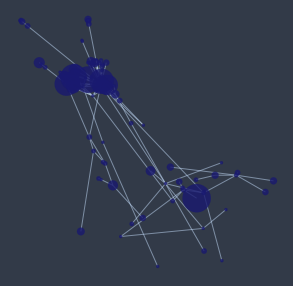

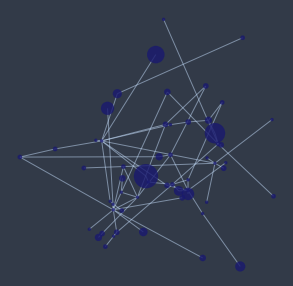

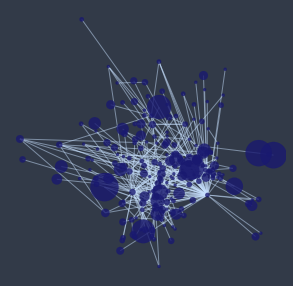

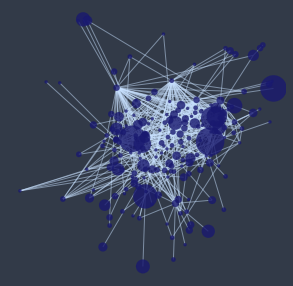

In [412]:
graph(2)
graph(3)
graph(4)
graph(7)

## Sentiment analysis

Number of communities: 15.0

Actual size of each community:
[3, 4, 4, 12, 14, 32, 36, 37, 38, 46, 53, 86, 93, 138, 141]

Bins:
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]


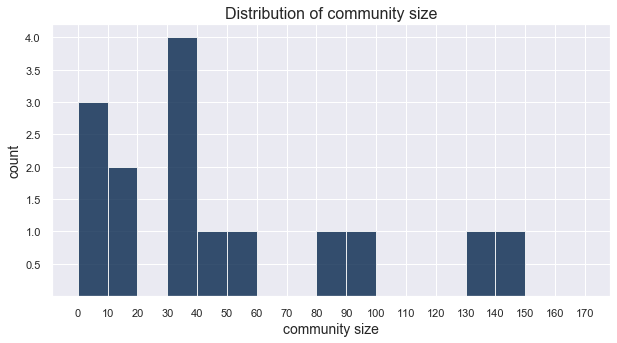

In [413]:
# get communities
partition = community.best_partition(giant, random_state=26)
size = float(len(set(partition.values())))
print(f'Number of communities: {size}')

# get communities and sizes
values = [val for val in partition.values()]
bins, counts = np.unique(values, return_counts=True)
print('\nActual size of each community:')
print(sorted(counts))

# define bins 0-10,10-20, 20-30 etc
bins_def = [x*10 for x in list(range(18))]

print('\nBins:')
print(bins_def)

# create histogram
sns.set()
plt.figure(figsize=(10, 5))
plt.hist(counts, color=blue[4], bins=bins_def, alpha=0.8)
plt.xticks(bins_def)
plt.yticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.xlabel('community size', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('Distribution of community size', fontsize=16)
plt.show()

In [414]:
def tokenize(df,col):
    df[f'Tokens_{col}'] = ""
    for i,content in enumerate(df[col]):
        try:
            text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
            sw = stopwords.words("english") # set stopwords
            wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
            words1= [t.lower() for t in text] # lower letters
            words11 = [t for t in words1 if t not in sw]   # remove stopwords
            words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
            words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers
            df[f'Tokens_{col}'][i] = words3
        except:
            print(i)

### Wordclouds

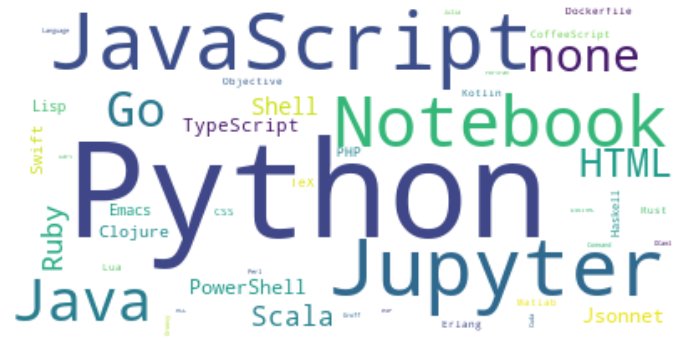

In [415]:
# create WordCloud
ll =' '.join(df['main_language'].fillna('none').tolist())
wordcloud = WordCloud(background_color='white', collocations = False).generate(ll)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

In [416]:
# create WordCloud
wordcloud = WordCloud(background_color='white', collocations = False).generate_from_frequencies(TF)

# plot the WordCloud image         
plt.figure(figsize=(10, 5), facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

AttributeError: 'str' object has no attribute 'items'

In [ ]:
# create WordCloud
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(TF_bio)

# plot the WordCloud image         
plt.figure(figsize=(10, 5),facecolor = None)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout() 
plt.show()